In [1]:
# Import code from our own files
from full_spectrum_plot import plot_spectrum, plot_spectrum_line_ids
from ch3cn_fits import ch3cn_model, ch3cn_fitter
from spectral_ids import line_ids
from lte_modeling_tools import nupper_of_kkms
# Import packages
from astropy import units as u
from astropy import constants
from astroquery.splatalogue import Splatalogue
import numpy as np
from vamdclib import nodes
from vamdclib import request as r
from vamdclib import specmodel as m
import pyspeckit
from pyspeckit.spectrum.models import model, lte_molecule
from spectral_cube import OneDSpectrum
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from scipy.optimize import curve_fit

# Define directory we're working with
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/spectra/'

Suds package not available. Load Vamdc-Nodes from static file
Register Class FitParameters in vamdclib.specmodel
Register Class Parameter in vamdclib.specmodel
Register Class Argument in vamdclib.specmodel
Register Class State in vamdclib.specmodel
Register Class AtomState in vamdclib.specmodel
Register Class AtomQN in vamdclib.specmodel
Register Class QuantumNumbers in vamdclib.specmodel
Register Class Partitionfunctions in vamdclib.specmodel
Register Class Atom in vamdclib.specmodel
Register Class Molecule in vamdclib.specmodel
Register Class RadiativeTransition in vamdclib.specmodel
Register Class CollisionalTransition in vamdclib.specmodel
Register Class Source in vamdclib.specmodel
Register DictClass Atoms in vamdclib.specmodel
Register DictClass Molecules in vamdclib.specmodel
Register DictClass RadiativeTransitions in vamdclib.specmodel
Register DictClass CollisionalTransitions in vamdclib.specmodel
Register DictClass Sources in vamdclib.specmodel


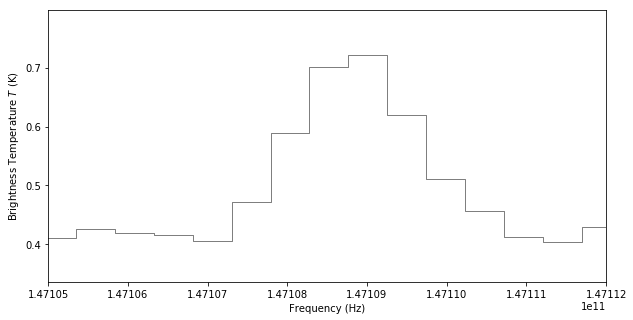

In [2]:
# Plot entire ladder
freq_spw = '146_spw51'
max_fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.max.fits'
freq_lo, freq_hi = 147.01*u.GHz, 147.17*u.GHz
plot_spectrum(max_fn, xmin=147.105*u.GHz, xmax=147.112*u.GHz) # for messing with
plt.show()

In [3]:
# List lines in this wavelength region, with tolerance for velocity shifts
tbl = Splatalogue.query_lines(freq_lo-0.1*u.GHz, freq_hi+0.1*u.GHz, 
                              chemical_name='CH3CN',
                              energy_max=500, # more lines w/ max energy > 140
                              energy_type='eu_k',
                              line_lists=['JPL'],
                              show_upper_degeneracy=True, 
                              show_qn_code=True)
# tbl.show_in_notebook()

# print(tbl['Species',
#           'Freq-GHz(rest frame,redshifted)',
#           'Resolved QNs',
#           'E_U (K)'].pprint(max_lines=1000))

# print(tbl.columns)

tbl_trimmed = tbl[tbl['Quantum Number Code']==202]
tbl_trimmed = tbl_trimmed[::-1]
# print(tbl_trimmed['Species',
#                   'Freq-GHz(rest frame,redshifted)',
#                   'Resolved QNs',
#                   'Log<sub>10</sub> (A<sub>ij</sub>)',
#                   'E_U (K)',
#                   'Upper State Degeneracy'].pprint(max_lines=1000))

# # Retrieve values for later use
line_freqs = tbl_trimmed['Freq-GHz(rest frame,redshifted)'].data
shifted_line_freqs = line_freqs-((40.5/299792)*line_freqs) # shift by velocity, here 40.5 km/s
line_names = tbl_trimmed['Resolved QNs'].data
einstein_A_coefficients = tbl_trimmed['Log<sub>10</sub> (A<sub>ij</sub>)'].data
E_upper = tbl_trimmed['E_U (K)'].data
g = tbl_trimmed['Upper State Degeneracy'].data

tbl_trimmed.show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Quantum Number Code,Linelist
0,CH3CNv=0,Methyl Cyanide,147.1745883,2e-07,--,--,8(0)-7(0),-2.6575,169.60673,11.02642,-3.7326,--,17.1828,24.72238,22.09202,31.78569,34.0,202,JPL
1,CH3CNv=0,Methyl Cyanide,147.1717519,2e-07,--,--,8(1)-7(1),-2.6748,166.91824,10.85164,-3.73957,--,22.1491,31.86782,27.05822,38.931,34.0,202,JPL
2,CH3CNv=0,Methyl Cyanide,147.1632441,2e-07,--,--,8(2)-7(2),-2.727,158.99516,10.33654,-3.76076,--,37.047,53.30272,41.95584,60.36548,34.0,202,JPL
3,CH3CNv=0,Methyl Cyanide,147.1490683,1e-07,--,--,8(3)-7(3),-2.5156,291.45821,18.94819,-3.79873,--,61.8731,89.02217,66.78146,96.08426,68.0,202,JPL
4,CH3CNv=0,Methyl Cyanide,147.1292302,1e-07,--,--,8(4)-7(4),-2.9482,127.19471,8.26914,-3.85798,--,96.6217,139.01798,101.5294,146.07911,34.0,202,JPL
5,CH3CNv=0,Methyl Cyanide,147.103738,1e-07,--,--,8(5)-7(5),-3.1316,103.33459,6.71796,-3.94843,--,141.2849,203.27878,146.19175,210.33869,34.0,202,JPL
6,CH3CNv=0,Methyl Cyanide,147.0726021,1e-07,--,--,8(6)-7(6),-3.0883,148.38336,9.64665,-4.09259,--,195.8526,281.79004,200.75841,288.84846,68.0,202,JPL
7,CH3CNv=0,Methyl Cyanide,147.0358351,1e-07,--,--,8(7)-7(7),-3.7949,39.74307,2.58376,-4.36401,--,260.3123,374.53377,265.21689,381.59042,34.0,202,JPL


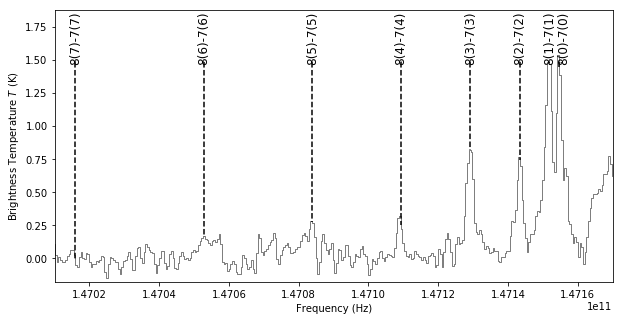

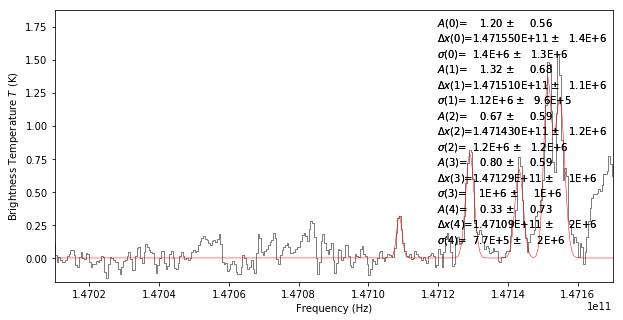

In [5]:
# Determine good guesses for line centers, velocity shifts, and line widths
# Doing Gaussians for now, even though Adam provided the CH3CN fitter which is different?
sp = OneDSpectrum.from_hdu(fits.open(max_fn)).to(u.K)
sp = pyspeckit.Spectrum.from_hdu(sp.hdu)
sp.data -= 0.4 # subtract baseline by hand because it seems to work better
# sp.baseline(include=(147.02*u.GHz, 147.04*u.GHz)) # subtract baseline using lineless area

fig = plt.figure(figsize=(10,5))
sp.plotter(figure=fig, xmin=freq_lo, xmax=freq_hi) # use this line to explore spectrum
sp.plotter.line_ids(line_names,shifted_line_freqs*(10**9),xval_units='Hz')

# Guesses are in the order amplitude, center, width in groups of three
guesses = [1.5, 147.154e9, 1e6, 
           1.5, 147.1521e9, 1e6, 
           0.8, 147.143e9, 1e6,
           0.8, 147.1285e9, 1e6, 
           0.3, 147.108e9, 1e6]

fig = plt.figure(figsize=(10, 5))
sp.plotter(figure=fig, xmin=freq_lo, xmax=freq_hi)
sp.specfit(guesses=guesses)
# sp.specfit(guesses=guesses, annotate=False, tied=('','','','','p[1]-delta','p[2]','','','p[2]','','','p[2]','','','p[2]'))
sp.xarr.convert_to_unit(u.km/u.s) # convert x-axis to km/s for integrations in next step

In [6]:
# Calculate upper level column density from integrated line intensity
pars = sp.specfit.parinfo.values

# limits = [(147.153, 147.16), # this is from the not-working way of integrating
#           (147.148, 147.1535),
#           (147.14, 147.146),
#           (147.127, 147.1325),
#           (147.105, 147.112)]

indices = [0, 1, 2, 3, 4] # define how many lines we are fitting
i = 0 # initialize parameter counter
N_upper = [] # initialize list of upper state column densities, to be calculated
for line in range(len(indices)): # was range(len(limits)) when I was using sp.specfit.integral
    amp, freq, width = u.Quantity(pars[i], u.K), pars[i+1], pars[i+2] # grab three parameters
    print(freq)
    width_kms = (width/freq)*(constants.c).to(u.km/u.s)
    kkms = np.sqrt(2*np.pi)*amp*width_kms
#     kkms = sp.specfit.integral(integration_limits=limits[i], integration_limit_units='GHz') # wrong?
    nupper = nupper_of_kkms(kkms, line_freqs[line], 10**(einstein_A_coefficients[line]))
    print(10**(einstein_A_coefficients[line]))
    N_upper.append(nupper.value)
    i += 3
print(N_upper)

147154872206.1788
0.00018509726429316478
147151361797.35062
0.0001821503457760298
147143201588.6638
0.00017347623980429908
147129081539.944
0.00015895346519516853
147108855308.13577
0.00013868196928083825
[1920465670848.957, 1741101028415.6252, 1002293863384.66, 1299330744255.5574, 390846189574.3508]


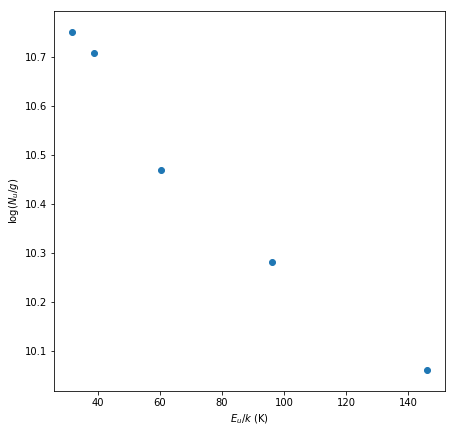

In [7]:
# Plot rotational diagram
fig = plt.figure(figsize=(7, 7))
plt.scatter(E_upper[:5], np.log10(N_upper/g[:5]))
plt.ylabel("$\log (N_u / g)$")
plt.xlabel("$E_u / k$ (K)")
plt.show()

In [8]:
def linear(x, m, b):
    return (m*x) + b

In [11]:
# Fit rotational temperature, inverse of slope
popt, pcov = curve_fit(linear, xdata = E_upper[:5], ydata = np.log10(N_upper/g[:5]))
fit = linear(E_upper[:5], *popt)

In [17]:
print(popt[0])
print(1./popt[0])

-0.006073104020798461
-164.66044325526389
